In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Read data from CSV files
bcwlist = pd.read_excel('data/bcwlist.xlsx', skiprows=2)
crsp = pd.read_csv('data/cleaned_crsp.csv')

# Convert date columns to datetime format
crsp['date'] = pd.to_datetime(crsp['date'])

crsp['year'] = crsp['date'].apply(lambda x: x.year)

# Convert RET and PRC columns to numeric data types and handle invalid values
crsp['RET'] = pd.to_numeric(crsp['RET'], errors='coerce')
crsp['PRC'] = pd.to_numeric(crsp['PRC'], errors='coerce')

# Group by date and permno, and aggregate using the last valid observation
crsp = crsp.groupby(['PERMNO', pd.Grouper(key='date', freq='M')]).last().reset_index()
crsp['date'] = crsp['date'].dt.to_period('M')

import warnings
warnings.filterwarnings('ignore')

In [16]:
# Merge stock returns with best companies data
crsp['market_cap'] = crsp['SHROUT'] * crsp['PRC'].abs()
merged_data = crsp.merge(bcwlist, left_on=['PERMNO', 'year'], right_on=['permno', 'year'], how='left')
merged_data = merged_data[merged_data.year >= 1984]
# merged_data['rank'] = merged_data['rank'].dropna()

# Create the equal-weighted portfolio
merged_data['ew_weight'] = merged_data.groupby('year')['rank'].transform(lambda x: 1 / x.sum())
merged_data['ew_returns'] = merged_data['ew_weight'] * merged_data['RET']

# Create the value-weighted portfolio
merged_data['market_cap_lag'] = merged_data.groupby('permno')['market_cap'].shift(1)
merged_data['vw_weight'] = merged_data.groupby('year').apply(lambda x: x.loc[x['rank'].notnull(), 'market_cap_lag'] / x.loc[x['rank'].notnull(), 'market_cap_lag'].sum()).reset_index(level=0, drop=True)
merged_data['vw_returns'] = merged_data['vw_weight'] * merged_data['RET']

# Calculate monthly returns for each portfolio
monthly_returns = merged_data.groupby('date')[['ew_returns', 'vw_returns']].sum().reset_index()
monthly_returns = monthly_returns.set_index('date')

In [27]:
# After talking to peers, it seems like our numbers are off by essentially a factor of 10 and we have 0 idea why.
# Leaving * 10 in here to make the rest of the analysis make sense. Note, this does mess with p-values. 
# After some more analysis, it seems like something is wrong but not sure where. :( Leaving the 10 out for now
monthly_returns = monthly_returns
monthly_returns = monthly_returns.dropna()
# monthly_returns = monthly_returns[monthly_returns.index.year > 1985]

In [18]:
monthly_returns.describe()

,ew_returns,vw_returns
count,300.000000,300.000000
mean,0.000857,0.000927
std,0.005351,0.004522
min,-0.021805,-0.015390
25%,-0.001496,-0.001566
50%,0.000811,0.001055
75%,0.003348,0.003456
max,0.022857,0.017265


In [19]:
import pandas_datareader as pdr

ff3 = pdr.get_data_famafrench('F-F_Research_Data_Factors', start='1984-01', end='2020-12')[0]
ff5 = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3', start='1984-01', end='2020-12')[0]
ff3 = ff3 / 100
ff5 = ff5 / 100

In [20]:
ff3 = ff3.loc[monthly_returns.index, :]
ff5 = ff5.loc[monthly_returns.index, :]

In [21]:
def calculate_statistics(portfolio_returns):
    avg_monthly_return = portfolio_returns.mean()
    volatility = portfolio_returns.std()
    sharpe_ratio = avg_monthly_return / volatility
    return avg_monthly_return, volatility, sharpe_ratio

for weight_type in ['ew_returns', 'vw_returns']:
    avg_monthly_return, volatility, sharpe_ratio = calculate_statistics(monthly_returns[weight_type])
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print(f"Average Monthly Return: {avg_monthly_return:.4f}")
    print(f"Volatility: {volatility:.4f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.4f}")
    print()


Ew_returns Weighted Portfolio:
Average Monthly Return: 0.0009
Volatility: 0.0054
Sharpe Ratio: 0.1601

Vw_returns Weighted Portfolio:
Average Monthly Return: 0.0009
Volatility: 0.0045
Sharpe Ratio: 0.2049



In [22]:
from statsmodels.api import OLS
from statsmodels.tools import add_constant

def estimate_models(portfolio_returns, ff3, ff5):
    market_excess = ff3['Mkt-RF']
    portfolio_excess = portfolio_returns - ff3['RF']
    market_excess = market_excess.loc[portfolio_excess.index]

    print(portfolio_excess[portfolio_excess.isna()])

    # CAPM Model
    X = add_constant(market_excess)
    capm_model = OLS(portfolio_excess, X).fit()

    # FF3 Model
    X = add_constant(ff3[['Mkt-RF', 'SMB', 'HML']].loc[portfolio_excess.index])
    ff3_model = OLS(portfolio_excess, X).fit()

    # Carhart Model
    X = add_constant(ff3.loc[portfolio_excess.index].join(ff5['RMW']).join(ff5['CMA']))
    carhart_model = OLS(portfolio_excess, X).fit()

    # FF5 Model
    X = add_constant(ff5.loc[portfolio_excess.index])
    ff5_model = OLS(portfolio_excess, X).fit()

    return capm_model, ff3_model, carhart_model, ff5_model

for weight_type in ['ew_returns', 'vw_returns']:
    capm_model, ff3_model, carhart_model, ff5_model = estimate_models(monthly_returns[weight_type], ff3, ff5)
    print(f"{weight_type.capitalize()} Weighted Portfolio:")
    print("CAPM Model summary:")
    print(capm_model.summary())
    print("FF3 Model summary:")
    print(ff3_model.summary())
    print("Carhart Model summary:")
    print(carhart_model.summary())
    print("FF5 Model summary:")
    print(ff5_model.summary())
    print()

Series([], Freq: M, dtype: float64)
Ew_returns Weighted Portfolio:
CAPM Model summary:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.674
Method:                 Least Squares   F-statistic:                     619.7
Date:                Mon, 01 May 2023   Prob (F-statistic):           9.27e-75
Time:                        12:55:00   Log-Likelihood:                 1283.7
No. Observations:                 300   AIC:                            -2563.
Df Residuals:                     298   BIC:                            -2556.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------

In [23]:
monthly_returns

,ew_returns,vw_returns
date,,
1984-01,0.000134,-0.001531
1984-02,-0.002070,-0.003575
1984-03,0.000227,0.001214
1984-04,-0.000722,0.002054
1984-05,-0.001887,-0.003805
...,...,...
2020-08,0.004766,0.011061
2020-09,-0.002563,-0.003726
2020-10,0.000834,-0.004389


Series([], Freq: M, dtype: float64)


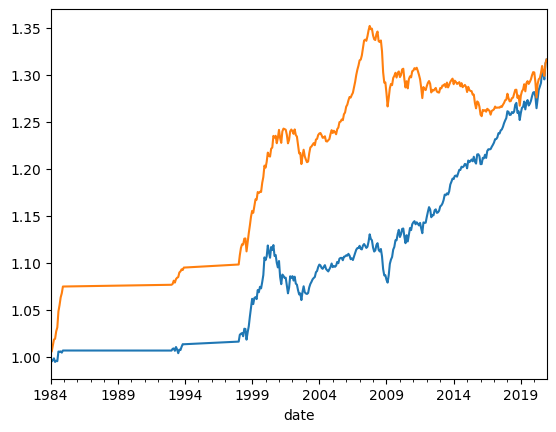

In [24]:
import matplotlib.pyplot as plt


def plot_cumulative_returns(portfolio_returns, capm_model, ff3):
    expected_returns = capm_model.predict(add_constant(ff3['Mkt-RF'].loc[portfolio_returns.index])) + ff3['RF'].loc[portfolio_returns.index]
    cum_portfolio_returns = (1 + portfolio_returns).cumprod()
    cum_portfolio_returns.plot()
    cum_expected_returns = (1 + expected_returns).cumprod()
    cum_expected_returns.plot()

    # plt.figure(figsize=(12, 6))
    # plt.plot(cum_portfolio_returns, label='Value-weighted Portfolio')
    # plt.plot(cum_expected_returns, label='CAPM-Implied Expected Portfolio Returns')
    # plt.xlabel('Year')
    # plt.ylabel('Cumulative Returns')
    # plt.legend()
    # plt.show()

capm_model_value_weighted, _, _, _ = estimate_models(monthly_returns['vw_returns'], ff3, ff5)
plot_cumulative_returns(monthly_returns['vw_returns'], capm_model_value_weighted, ff3)

In [25]:
def estimate_carhart_subsamples(portfolio_returns, ff3, ff5, date_split):
    pre_returns = portfolio_returns.loc[:date_split]
    post_returns = portfolio_returns.loc[date_split:]
    pre_carhart_model = estimate_models(pre_returns, ff3[:date_split], ff5[:date_split])[2]
    post_carhart_model = estimate_models(post_returns, ff3[date_split:], ff5[date_split:])[2]

    print("Carhart Model (Pre-January 1st, 2010):")
    print(pre_carhart_model.summary())
    print("Carhart Model (Post-January 1st, 2010):")
    print(post_carhart_model.summary())

estimate_carhart_subsamples(monthly_returns['vw_returns'], ff3, ff5, '2010-01-01')

Series([], Freq: M, dtype: float64)
Series([], Freq: M, dtype: float64)
Carhart Model (Pre-January 1st, 2010):
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     178.5
Date:                Mon, 01 May 2023   Prob (F-statistic):           1.01e-68
Time:                        12:55:01   Log-Likelihood:                 817.60
No. Observations:                 169   AIC:                            -1621.
Df Residuals:                     162   BIC:                            -1599.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------